# Sensitivity analysis

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

# setting the style
plt.style.use('seaborn-whitegrid')

# setting the annotation default font 
plt.rcParams["font.family"] = "roboto"
plt.rcParams["font.size"] = 10

plt.rcParams["figure.autolayout"] = False


plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False

from custom_func import run_cba

### Defining the parameters
The methodology of the cost-benefit analysis is informed by the following works:

* Raux, C., Souche, S., & Pons, D. (2012). The efficiency of congestion charging: Some lessons from cost-benefit analyses. Research in Transportation Economics, 36 (1), pp.85-92. doi:10.1016/j.retrec.2012.03.006
* Danna, S., Mori, K., Vela, J., & Michelle, W. (2012). A benefit-cost analysis of road pricing in downtown Seattle.  Evans School Review, 2 (1), pp. 26-46. https://web.archive.org/web/20170811213013id_/https://depts.washington.edu/esreview/wordpress/wp-content/uploads/2012/12/ESR-2012-A-Benefit-Cost-Analysis-of-Road-Pricing-in-Downtown-Seattle.pdf

Based on their methodology, the parameters are defined:
* Discount rate: 5%
* Price elasticity of traffic volume: 0.5
* Travel time elasticity to traffic volume: 0.1471
* Traffic accident elasticity to traffic volume: 0.1513

The following benefits are identified:
* Time saving
* Pollution reduction
* Reliability benefits
* Reduction in traffic accident

The following costs are identified:
* Operational cost
* Investment cost
* Public transit subsidy


### Baseline Cost-Benefit Analysis

#### Percentage reduction in journey time
$\quad \epsilon_{t,p} \times \frac{Congestion\, Charge}{Cost\, of\, Driving} $

$= 0.5 \times \frac{14}{17.8\times 1.55} $

$= 0.2537$



#### Reduction in journey time
$\quad \epsilon_{ts,tvol} \times \Delta \%traffic \times time\, cost $

$= 0.1471 \times 0.2537 \times 817\textrm{million} $

$= 304 \textrm{million per year} $

#### Reduction in time budget
$time\,cost =1434000\times 260 \times \frac{40}{60} \times 32.86=\textrm{8 billion}$



$\quad \frac{1}{3} \times 304 \textrm{million per year} $

$= 102 \textrm{million per year} $

#### Reduction in pollution
##### CO_2

$\quad Emission\,per\,mile^{[1]} \times Reduction\, in\,Milelage\times Cost^{[2]}$

$ = 0.411 \times \textrm{102 million}\times 0.033 $

$= \textrm{23 million per year}$


#### NO_x
$\quad Emission\,per\,mile^{[3]} \times Reduction\, in\,Milelage\times Cost^{}[2] $

$=0.00007 \times   \textrm{102 million}\times 0.081 $

$= \textrm{0.01 million per year} $


#### Accidents
$\quad\epsilon_{ta,tvol} \times \Delta \%traffic \times cost $

$= 0.1513 \times 0.2537 \times \textrm{4290 million}$

$= \textrm{164 million per year}$

#### Operational cost

$\quad \textrm{38.9 million}^{[1]} \times 1.24^{[2]} \times 3.998^{[3]}$

$=\textrm{193 million per year}$


#### Investment Cost
$\quad  \textrm{200 million}^{[1]} \times1.32^{[2]}\times 1.619^{[3]}$

$=\textrm{427 million}$

#### Public transit subsity
##### Current Coverage Rate
$\quad \frac{263,635}{753,406}\times 100\%$

$=35.125\%$

### Total Cost of Public Transit Subsidy
$\quad \textrm{48.9 million}^{[1]}\times \frac{50\%}{35.125\%}$

$=\textrm{95 million}$

In [2]:
def run_cba(dis_rate = 0.05, charge = 14, elas = 0.5,avg_dis=17.8,cost_drive = 1.55, time_cost =32.86):
    """
    conduct cost-benefit analysis.
    The function return all the identified cost and benefits in a dictionary
    """
    # determine the percentage change in traffic flow with respect to price
    delta_traffic = elas *charge/(avg_dis*cost_drive) # percentage change in traffic volume default set as 0.5*14/(17.8 * 1.55) =0.2537
    delta_mil = delta_traffic * 717000 * 2 * 17.8 *260 # annual change in the aggregate mileage

    # determine the common ratio for perpetual calculation (discount rate)
    cm = 1/(1+dis_rate)
    
    # determine the annual cost and benefit in million
    B_timesaving  = (0.1471 * delta_traffic) * (717000* 260*2) *(40/60)*time_cost  /1000000
    B_reliability = B_timesaving /3
    #CO2
    co2 =  0.411* delta_mil * 0.033 / 1000000
    #NOx
    nox =   0.00007 *delta_mil * 0.081 / 1000000
    B_pollution   = (co2 + nox) 

    # accident
    B_accident    = delta_traffic * 0.1513 * 4290

    # cost
    C_operational = 38.9*1.24*3.998 
    C_subsidy     = 95
    # upfront investment
    C_investment  = 200*1.32*1.619 

    # aggregate npv of benefit and cost
    agg_ben = (B_timesaving + B_reliability + B_pollution + B_accident) /  (1-cm)
    agg_cos = (C_operational + C_subsidy) / (1-cm) +C_investment
    BRC = agg_ben / agg_cos
    BRC_dummy = BRC >= 1

    dict = {    'Discount Rate':dis_rate,
                'Charge':charge,
                'Elasticity':elas,
                'B_timesaving':B_timesaving,
                'B_reliability':B_reliability,
                'B_pollution':B_pollution,
                'B_accident':B_accident,
                'C_operational':C_operational,
                'C_investment':C_investment,
                'C_subsidy': C_subsidy,
                'Benefit-Cost Ratio':BRC,
                'Benefit-Cost Ratio - Dummy':BRC_dummy}
    #list =  [[dis_rate,charge,elas,B_timesaving,B_reliability,B_pollution,B_accident,C_operational,C_investment,C_subsidy, BRC]]
    
    return dict
                

In [3]:
dis_rate    = [x for x in np.arange(0.02,0.15,0.002)]
charges     = [x for x in np.arange(9,23,0.5)]
elases      = [x for x in np.arange(0.2,0.3,0.01)]

col =[  'Discount Rate', 'Charge','Elasticity','B_timesaving','B_reliability','B_pollution','B_accident',
        'C_operational', 'C_investment','C_subsidy','Benefit-Cost Ratio']
df = pd.DataFrame(columns = col)
for dis in dis_rate:
    #for charge in charges:
    for elas in elases:
            data = run_cba(dis_rate = dis, charge = 14, elas = elas)
            df = df.append(data, ignore_index = True)

df.head()

,Discount Rate,Charge,Elasticity,B_timesaving,B_reliability,B_pollution,B_accident,C_operational,C_investment,C_subsidy,Benefit-Cost Ratio,Benefit-Cost Ratio - Dummy
0,0.02,14,0.20,121.932030,40.644010,9.138736,65.872258,192.847528,427.416,95,0.802040,0.0
1,0.02,14,0.21,128.028631,42.676210,9.595672,69.165871,192.847528,427.416,95,0.842142,0.0
2,0.02,14,0.22,134.125233,44.708411,10.052609,72.459484,192.847528,427.416,95,0.882245,0.0
3,0.02,14,0.23,140.221834,46.740611,10.509546,75.753097,192.847528,427.416,95,0.922347,0.0
4,0.02,14,0.24,146.318436,48.772812,10.966483,79.046710,192.847528,427.416,95,0.962449,0.0


In [4]:
# Elasticity
y = np.linspace(0.2,0.3,100)

dt = y * 14 / (17.8*1.55)  # delta traffic
dm = dt * 717000 * 2 * 17.8 * 260

b1= 0.1471 * dt * (717000*260*2)  *(40/60)*32.86 /1000000 * 4/3 # time saving and reliability
b2= 0.411 * dm * 0.033 / 1000000 + 0.00007 * dm *  0.081 / 1000000
b3= dt * (0.1513 * 4290)
b = b1+ b2 + b3

c = (38.9*1.24*3.998) + 95
cin = 200*1.32*1.619

# zero-welfare discount rate
x = -(1/ (((b- c)/cin)-1)  )-1


Vairable of interest:
* discount rate
* Benefit-cost Ratio
* Charge
* Elasticity

## Sensitivity Analysis 

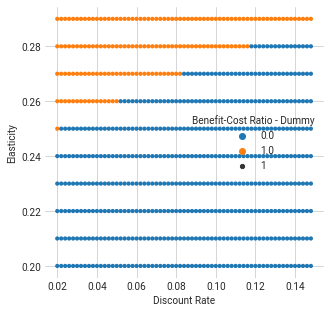

In [5]:
# plot the sensitivity analysis
fig, ax = plt.subplots(figsize = (5,5))
fig.patch.set_alpha(0)

p1 = sns.scatterplot(x = "Discount Rate",y='Elasticity',hue = 'Benefit-Cost Ratio - Dummy', data = df, linewidth = 0, ax = ax, size = 1)

#ax.set_xlim(0.015,0.15)
#ax.set_ylim(0.20,0.3)

/Users/Tra_FIT/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


AttributeError: 'AxesSubplot' object has no attribute 'savefig'

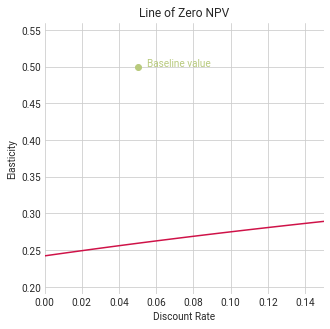

In [7]:
# plot the sensitivity analysis
fig, ax = plt.subplots(figsize = (5,5))
fig.patch.set_alpha(0)

p2 = sns.lineplot(x,y,color = '#cf1248')
ax.scatter(0.05, 0.5 ,color = "#b8ca7d") # baseline scenario
ax.text(0.055, 0.5 ,'Baseline value', color = "#b8ca7d")
ax.set_title('Line of Zero NPV')
ax.set_xlabel('Discount Rate')
ax.set_ylabel('Elasticity')
ax.set_xlim(0,0.15)
ax.set_ylim(0.19,0.56)
ax.savefig('line_of_zeroNPV.jpg', dpi = 150, bbox_to_inches = 'tight')

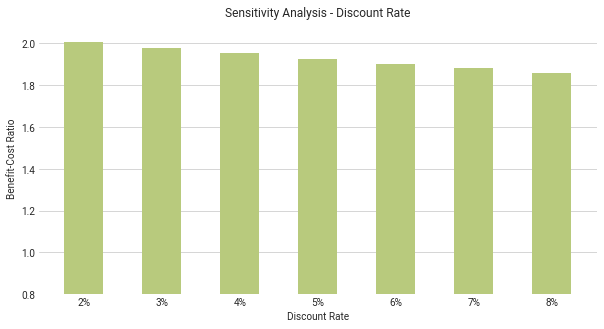

In [8]:
df_dr = pd.DataFrame(columns = col)
n = 0 
for x in np.arange(0.02,0.09,0.01):
    data = run_cba(dis_rate = x)
    df_dr = df_dr.append(data, ignore_index = True)

fig, ax = plt.subplots(figsize = (10,5))
fig.patch.set_alpha(0)

x = ['2%','3%','4%','5%','6%','7%','8%']
ax.bar(x,df_dr['Benefit-Cost Ratio'],width = 0.5, color = "#b8ca7d")


#ax.set_xlim(0.015,0.08)
ax.set_ylim(0.8,2.1)
ax.set_title("Sensitivity Analysis - Discount Rate")
ax.set_ylabel("Benefit-Cost Ratio")
ax.set_xlabel("Discount Rate")
ax.xaxis.grid(False)

plt.savefig('sensitivity_analysi-dr.png', dpi = 300 , transparent = True)



In [9]:
df_dr

,Discount Rate,Charge,Elasticity,B_timesaving,B_reliability,B_pollution,B_accident,C_operational,C_investment,C_subsidy,Benefit-Cost Ratio,Benefit-Cost Ratio - Dummy
0,0.02,14,0.5,304.830074,101.610025,22.846839,164.680645,192.847528,427.416,95,2.005101,1.0
1,0.03,14,0.5,304.830074,101.610025,22.846839,164.680645,192.847528,427.416,95,1.977937,1.0
2,0.04,14,0.5,304.830074,101.610025,22.846839,164.680645,192.847528,427.416,95,1.952000,1.0
3,0.05,14,0.5,304.830074,101.610025,22.846839,164.680645,192.847528,427.416,95,1.927211,1.0
4,0.06,14,0.5,304.830074,101.610025,22.846839,164.680645,192.847528,427.416,95,1.903493,1.0
5,0.07,14,0.5,304.830074,101.610025,22.846839,164.680645,192.847528,427.416,95,1.880779,1.0
6,0.08,14,0.5,304.830074,101.610025,22.846839,164.680645,192.847528,427.416,95,1.859007,1.0


#### Sensitivity Analysis - Elasticity
Holding all other variable constant with the baseline figure, determine the cost-benefit ratio with a range of elasticity.

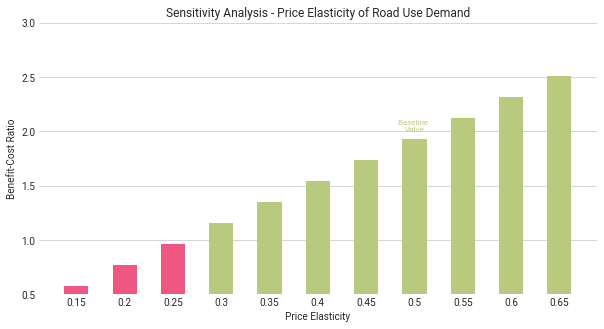

In [10]:
df_el = pd.DataFrame(columns = col)
plt.rcParams["font.size"] = 10
for x in np.arange(0.15,0.7,0.05):
    data = run_cba(elas = x)
    df_el = df_el.append(data, ignore_index = True)

fig, ax = plt.subplots(figsize = (10,5))
fig.patch.set_alpha(0)

x = ['0.15','0.2','0.25','0.3','0.35','0.4','0.45','0.5','0.55','0.6','0.65']
c = ['#f05682','#f05682','#f05682',"#b8ca7d","#b8ca7d","#b8ca7d","#b8ca7d","#b8ca7d","#b8ca7d","#b8ca7d","#b8ca7d"]
ax.bar(x,df_el['Benefit-Cost Ratio'],width = 0.5, color = c)


#ax.set_xlim(0.015,0.08)
ax.set_ylim(0.5,3)
ax.set_title("Sensitivity Analysis - Price Elasticity of Road Use Demand")
ax.set_ylabel("Benefit-Cost Ratio")
ax.set_xlabel("Price Elasticity")
ax.xaxis.grid(False)
ax.text(7,2, "Baseline \nValue", fontsize = 8, horizontalalignment = 'center', color = "#b8ca7d")

plt.savefig('sensitivity_analysi-el.png',dpi = 400 , transparent = True)